#### Remapping MPAS grid to lat-lon grid
- read MPAS grid and dataset
- create target lat-lon mesh
- regridding by scipy.interpolate griddata
- Saving weights: an faster way for scipy.interpolate griddata
- LinearNDInterpolator: with a pre-computed Delaunay triangulation:
  another way to store the weights used by scipy griddata for re-use

Ming Ge April 2025

reference:
https://stackoverflow.com/questions/20915502/speedup-scipy-griddata-for-multiple-interpolations-between-two-irregular-grids

In [1]:
import numpy as np
import xarray as xr
import uxarray as ux

import scipy.spatial.qhull as qhull
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import griddata

import holoviews as hv
hv.extension("matplotlib")
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

#### Speed up scipy.interpolate.griddata  
The way scipy.interpolate.griddata works:
- First, a call to sp.spatial.qhull.Delaunay is made to triangulate the irregular grid coordinates.
- Then, for each point in the new grid, the triangulation is searched to find in which triangle (actually, in which simplex, which in your 3D case will be in which tetrahedron) does it lay.
- The barycentric coordinates of each new grid point with respect to the vertices of the enclosing simplex are computed.
- An interpolated values is computed for that grid point, using the barycentric coordinates, and the values of the function at the vertices of the enclosing simplex.

The first three steps are identical for all interpolations, so store each new grid point the indices of the vertices of the enclosing simplex and the weights for the interpolation to minimize the amount of computations:

In [2]:
# Interpolation functions
def interp_weights(xy, uv, d=2):
    '''
    First, a call to sp.spatial.qhull.Delaunay is made to triangulate the irregular grid coordinates.
    Then, for each point in the new grid, the triangulation is searched to find in which triangle (actually, in which simplex, which in your 3D case will be in which tetrahedron) does it lay.
    The barycentric coordinates of each new grid point with respect to the vertices of the enclosing simplex are computed.
    '''
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

# This is very fast
def interpolate(values, vtx, wts):
    '''
    An interpolated values is computed for that grid point, using the barycentric coordinates, and the values of the function at the vertices of the enclosing simplex.
    '''
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

# The only thing that griddata does that is not contemplated here is assigning fill_value to points that have to be extrapolated.
# This is done by checking for points for which at least one of the weights is negative
def interpolate(values, vtx, wts, fill_value=np.nan):
    ret = np.einsum('nj,nj->n', np.take(values, vtx), wts)
    ret[np.any(wts < 0, axis=1)] = fill_value
    return ret

#### Read MPAS data

In [3]:
flnm_grid = '/glade/campaign/mmm/c3we/mingge/MPAS-Model/1994/x4.163842.static.nc'
flnm_data = '/glade/campaign/mmm/c3we/mingge/MPAS-Model/1994/diag.1994-11-10_00.00.00.nc'

ds = ux.open_dataset(flnm_grid,flnm_data) 
da = ds["temperature_surface"][0]

ds_grid = xr.open_dataset(flnm_grid)

#### Define lat-lon mesh

In [4]:
lat_res = 1
lon_res = 1
lats = np.arange(-89.5, 89.5, lat_res)
lons = np.arange(0, 360, lon_res)
    
lon2d, lat2d = np.meshgrid(lons, lats)

grid_target = np.append(lon2d.flatten()[:,None], lat2d.flatten()[:,None], axis=1)

# radians to degree
lon_mpas = np.degrees(ds_grid.lonCell.data)
lat_mpas = np.degrees(ds_grid.latCell.data)

points = np.array([lon_mpas, lat_mpas]).transpose()

#### Interpolate by scipy.interpolate griddata

CPU times: user 93.2 ms, sys: 199 μs, total: 93.4 ms
Wall time: 104 ms


Text(0.5, 1.0, 'Nearest')

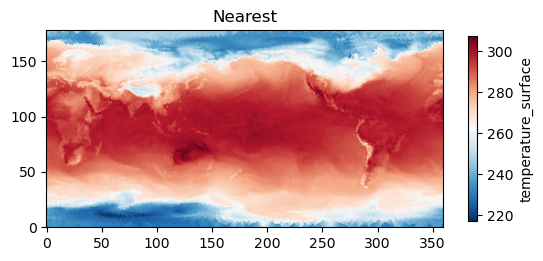

In [5]:
%%time
#use the LinearNDInterpolator Scipy function with a pre-computed Delaunay triangulation:
# for large datasets, using scipy.interpolate.griddata can be slow
# method = 'nearest', 'linear', 'cubic'
grid_z0 = griddata(points, da.values, (lon2d, lat2d), method='nearest')

plt.imshow(grid_z0, origin='lower',cmap='RdBu_r')
plt.colorbar(label='temperature_surface', shrink = 0.5)
plt.title('Nearest')

#### Interpolation by storing each new grid point the indices of the vertices of the enclosing simplex and the weights for the interpolation 

In [6]:
vtx, wts = interp_weights(points, grid_target)
data_1d = interpolate(da.data, vtx, wts)
data_2d = data_1d.reshape(lon2d.shape[0], lon2d.shape[1])

#### Construct a xarray and plot

Text(0.5, 1.0, 'Interpolated temperature_surface')

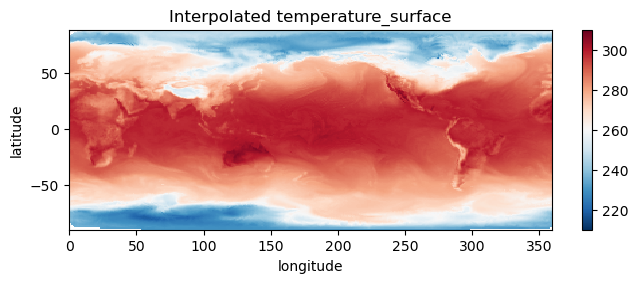

In [7]:
coords= {
    'latitude':lats,
    'longitude':lons
}

data_xr = xr.DataArray(data_2d, coords)

data_xr.plot(cmap='RdBu_r', figsize=(7.8, 2.6), vmin=210, vmax=310)
plt.title("Interpolated temperature_surface")

:Image   [x,y]   (x_y temperature_surface)
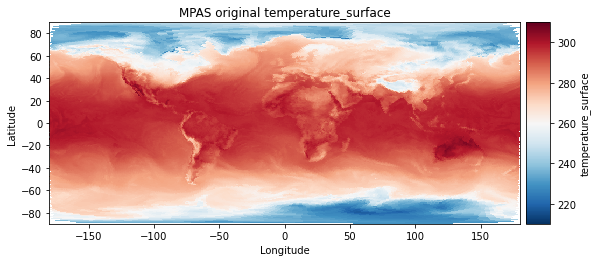

In [8]:
da.plot(cmap='RdBu_r', clim=(210, 310), title = 'MPAS original temperature_surface')

#### use the LinearNDInterpolator Scipy function with a pre-computed Delaunay triangulation  to avoid re-compute weigths each time. 

CPU times: user 1.08 s, sys: 12.2 ms, total: 1.09 s
Wall time: 1.11 s


Text(0.5, 1.0, 'LinearNDInterpolator')

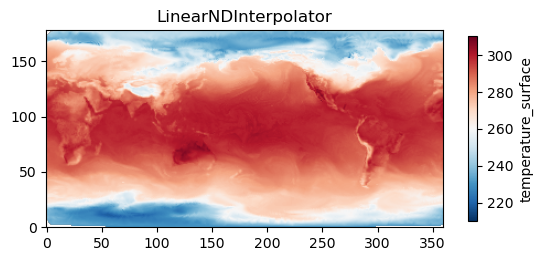

In [9]:
%%time
# Compute the triangulation
tri = Delaunay(points)  

# Perform the interpolation with the given values:
interpolator = LinearNDInterpolator(tri, da.values)
values_mesh2 = interpolator( (lon2d, lat2d))

plt.imshow(values_mesh2, vmin = 210,vmax=310,  origin='lower',cmap='RdBu_r')
plt.colorbar(label='temperature_surface', shrink = 0.5)
plt.title('LinearNDInterpolator')